<h1><center>Practice of Large Scale Machine Learning - TP1 Avazu<center></h1>
<h2><center>IA317<center></h2>


# Introduction

In online advertising, click-through rate (CTR) is a very important metric for evaluating ad performance. As a result, click prediction systems are essential and widely used for sponsored search and real-time bidding. The goal of this TP is to build and test prediction models on 11 days of Avazu data.

#### For any remark or suggestion, please feel free to contact us at: 
#### pascal.bianchi@telecom-paris.fr
#### nidham.gazagnadou@telecom-paris.fr
#### kevin.elgui@telecom-paris.fr

In [1]:
import sys
import os
#from google.colab import drive

#drive.mount('/content/gdrive')
#root_path = './../'  # your new root path

#sys.path.append(os.path.join(root_path, 'notebooks')) # for importing from utils.py

<font color="red">**Question:**
    Import the needed packages: numpy, pandas etc..
</font>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

In [3]:
## Try to run de cell
from utils import plotlift

# The dataset

<font color="red">**Question:**
    Load the data *'data_tp/train-1000000'* into a pandas DataFrame. Use the function 'os.path.join()' to indicate the full path. Then, display the first lines with the ".head()" method.
    <br>
</font>
**Remark**: the features meaning is available at https://www.kaggle.com/c/avazu-ctr-prediction/data

In [4]:
df = pd.read_csv( 'data_tp/train-1000000' )

In [5]:
df.head() # Fill here

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,3.983206e+18,0,14102915,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,2,4687,320,50,423,2,39,100148,32
1,7.756884e+18,0,14103007,1002,0,cb809abf,74acf31a,50e219e0,ecad2386,7801e8d9,...,0,0,17894,320,50,2039,2,39,100077,32
2,6.941774e+17,0,14102711,1005,0,85f751fd,c4e18dd6,50e219e0,e9739828,df32afa9,...,1,0,22684,320,50,2619,1,163,100055,71
3,2.664154e+18,1,14102903,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,...,1,0,23222,320,50,2676,0,35,100176,221
4,1.480510e+19,0,14102902,1005,1,791b5571,fd13bc73,f028772b,ecad2386,7801e8d9,...,1,0,8330,320,50,761,3,175,100081,23


<font color="red">**Question:**
    What is the 'click' frequency in the dataset?
    <br>
    Hint: 'click' is a binary output (0 or 1)
</font>

In [6]:
df['click'].sum() / len(df) # Fill here

0.169971

<font color="blue">
The Click frequency is 0.169971
</font>

We note that the Avazu dataset is very unbalanced. The 'click' class represents less than a fifth of the whole database. We already know that a classifier always predicting 'click'=0 will have good preformances in terms of error rate (around 0.17). The ROC and lift curves will be better performance metrics.

<font color="red">**Question:**
    What are the categorical features? Using the 'df.nunique()' method, compute the number of distincts values for each of these features.
</font>

In [10]:
categorical_features = df.loc[:,df.dtypes == 'object']
categorical_features.nunique()

site_id            2651
site_domain        2871
site_category        22
app_id             3157
app_domain          198
app_category         26
device_id        150501
device_ip        555248
device_model       5168
dtype: int64

<font color="blue">
The categorical features are : site_id, site_domain, site_category, app_id, app_domain, app_category, device_id, device_ip,  device_model    
</font>

<font color="red">**Question:**
    If one does a dummy encoding of all categorical variables, what would be the dimension of the model?
    In other words: what would be the dimension of our big feature vector encoded with dummies. 
    <br>
    Hint: if you have just 1 feature with 3 categories A, B and C, you would have a vector of dimension 3 (or 2 if you use drop_first=True).
</font>

In [11]:
categorical_features.nunique().sum()

719842

<font color="blue"> New vector dimension will be 719842. </font>

<font color="red">**Question:**
    Analyze the 'hour' column: which format is used? How can we transform/simply this feature?
</font>

In [12]:
print(df['hour'].head()) # Fill here
print(df['hour'].tail()) # Fill here

0    14102915
1    14103007
2    14102711
3    14102903
4    14102902
Name: hour, dtype: int64
999995    14102602
999996    14102101
999997    14102318
999998    14102908
999999    14102600
Name: hour, dtype: int64


<font color="blue"> The time format is YYMMDDHH. </font>

<font color="red">**Question:**
    Run and understand the following script.
</font>

In [13]:
import datetime

def datesplit(originalDate):
    originalDate = str(originalDate)    
    year  = int("20" + originalDate[0:2])
    month = int(originalDate[2:4])
    day   = int(originalDate[4:6])
    hour  = int(originalDate[6:8])
    
    return datetime.datetime(year, month, day, hour)

# Exemple :
datesplit(14102915).weekday(), datesplit(14102915).hour

(2, 15)

<font color="red">**Question:**
    Using the ".apply( ... )" method, create a 'weekday' for the day of the week. Then, replace the 'hour' column by the hour.
</font>

To answer this question you have to understand that applies takes a function as argument
<br>
"lambda x: ... " is used to create local unamed function of x
<br>
Check the documentation: https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions

In [14]:
df['weekday'] = df['hour'].apply(lambda x: datesplit(x).weekday() ) # Fill here
df['hour'] = df['hour'].apply(lambda x: datesplit(x).hour ) # Fill here

<font color="red">**Question:**
    Using the ".groupby( ... )" method, visualize the influence of the hour and of the day on the 'click' frequency (take the ".mean()"!). To do so, plot 'click' vs 'hour' and 'click' vs 'weekday' curves.
    <br>
    Precise the name of the axes.
</font>

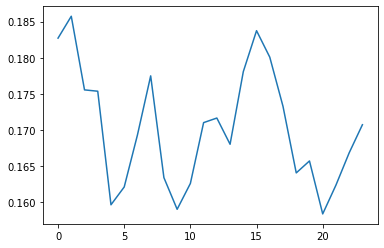

In [15]:
plt.plot(df.groupby(['hour']).mean()['click']); # Fill here for the influence of the hour

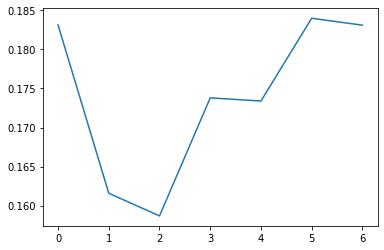

In [16]:
plt.plot(df.groupby(['weekday']).mean()['click']); # Fill here for the influence of the day

# Preliminary work and first model

Start by understanding the features with few modalities:
'hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21'.

<font color="red">**Question:**
    For instance, inspect the columns 'C15' (dimension of the advert) and 'site_category': visualize the clicks mean.
</font>

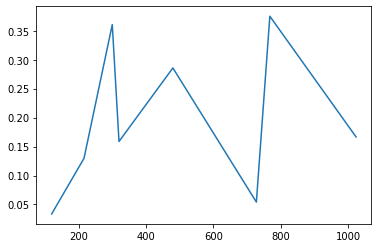

In [17]:
plt.plot(df.groupby(['C15']).mean()['click']); # Fill here for the influence of the day

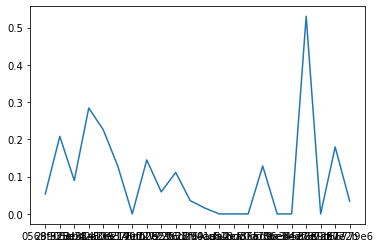

In [18]:
plt.plot(df.groupby(['site_category']).mean()['click']); # Fill here: inspect 'site_category' using '.groupby'

<font color="red">**Question:**
    Some site categories have a null click rate. Why? Display the 'count()' of each modality.
    <br><br>
    Hint: you can use the method ".value_counts()"
</font>

In [19]:
df.groupby(['site_category'])['click'].value_counts()# Fill here

site_category  click
0569f928       0           406
               1            23
28905ebd       0        144146
               1         37874
335d28a8       0          3050
               1           301
3e814130       0         54159
               1         21508
42a36e14       0            48
               1            14
50e219e0       0        356335
               1         52586
5378d028       0            11
70fb0e29       0           520
               1            88
72722551       0           636
               1            40
75fa27f6       0          3561
               1           446
76b2941d       0          2481
               1            92
8fd0aea4       0           186
               1             3
9ccfa2ea       0             5
a818d37a       0            81
bcf865d9       0            16
c0dd3be3       0           894
               1           132
c706e647       0             1
da34532e       0             1
dedf689d       1           331
               0  

<font color="blue"> Some site category have no click at all, that's why the click rate is null (cf previous plot). </font>

It is practical to visualize both columns in parallel:

In [20]:
col = 'C1'
a = pd.DataFrame([df.groupby(col).mean()['click'], df.groupby(col).count()['click']]).transpose()
a.columns = ['mean', 'count']
a.sort_values(by='count', ascending=False)

,mean,count
C1,,
1005,0.169474,918606.0
1002,0.211157,54907.0
1010,0.095497,22409.0
1012,0.177295,2854.0
1007,0.035591,871.0
1001,0.027027,222.0
1008,0.106870,131.0


<font color="red">**Question:**
    Divide the dataset into a training and test set with sklearn (use the following options: test_size=0.1, random_state=100).
    <br>
    Warning: do not use 'id' as a feature.
</font>

In [21]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['id','click'])
y = df['click']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=100)

# First work on a reduced number of features

<font color="red">**Question:**
    Put in a list the selected columns: 'hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21'.
</font>

In [22]:
some_columns = ['hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 
                'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21']

<font color="red"> 
- Importer CategoricalEncoder de sklearn.preprocessing.  
- Fitter le CategoricalEncoder sur les données de train restreintes aux colonnes ci-dessus.  
- Transformer les données de train et de test en dummies.
</font>

Pas besoin selon la version de sklearn

<font color="red">**Question:**
    <br> - Import OneHotEncoder from sklearn.preprocessing
    <br> - Transform the training and the test data restricted to the selected columns
</font>

In [23]:
from sklearn.preprocessing import OneHotEncoder #CategoricalEncoder
ohe = OneHotEncoder(handle_unknown='ignore')

In [24]:
ohe.fit(Xtrain[some_columns])
Xtrain_oh = ohe.transform(Xtrain[some_columns]).toarray() # fit the transformation of Xtrain restricted to selected columns
Xtest_oh = ohe.transform(Xtest[some_columns]).toarray() # and transform Xtest restricted to selected columns

<font color="red">**Question:**
    What is the new number of features?
</font>

In [25]:
Xtrain_oh.shape

(900000, 183)

<font color="blue"> There are 183 features. </font>

<font color="red">**Question:**
    Visualize the first row of the design matrix you have got. Do not forget to convert it into a "numpy.array" using the method ".toarray()".
</font>

In [23]:
Xtrain_oh[1,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

<font color="red">**Question:**
    Import and fit a logistic regression model on your the encoded data.
</font>

In [26]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear')
lr.fit(Xtrain_oh, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

<font color="red">**Question:**
    With '.predict' and 'predict_proba', display the hard and soft decision you get on test data.
</font>

In [27]:
hard = lr.predict(Xtest_oh)
soft = lr.predict_proba(Xtest_oh)

In [28]:
print('soft:',soft)
print('hard:',hard)

soft: [[0.75810331 0.24189669]
 [0.73404558 0.26595442]
 [0.79690021 0.20309979]
 ...
 [0.79251826 0.20748174]
 [0.78570489 0.21429511]
 [0.87847646 0.12152354]]
hard: [0 0 0 ... 0 0 0]


<font color="red">**Question:**
    Compute the probability of error using sklearn.metrics 'accuracy_score' function. Comment.
</font>

In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, hard)

0.83043

<font color="blue"> It is quite a good score but the dataset is unbalanced, there too few click in comparaison with the no-click. </font>

<font color="red">**Question:**
    Plot the ROC curve. Then compute the log loss and the Area Under the Curve ROC.
</font>

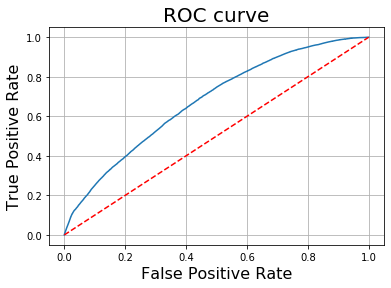

In [30]:
from sklearn.metrics import roc_curve

false_pos_rate, true_pos_rate, _ = roc_curve(ytest, soft[:,1])
plt.plot(false_pos_rate, true_pos_rate)

plt.grid()
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=20)
plt.show()

In [31]:
from sklearn.metrics import log_loss , roc_auc_score

log_loss(ytest, soft[:,1]), roc_auc_score(ytest, soft[:,1])

(0.42512237241698536, 0.6762770683130889)

<font color="red">**Question:**
    Import the 'plot_lift' function from 'utils.py' and plot the lift curve. What is the lift of the first fifth of the population identified by the test?
</font>

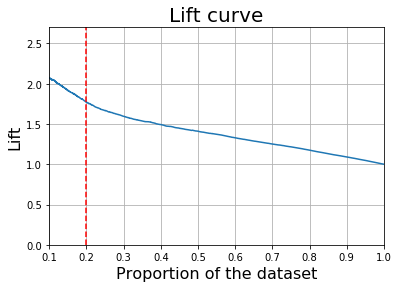

In [32]:
from utils import plotlift

plotlift(ytest, soft[:,1] )
# The following line just plots a vertical line for you to answer the second part of the question
plt.axvline(x= 0.2 , linestyle='--', color='r') # Fill here
plt.text
plt.xlabel('Proportion of the dataset', fontsize=16)
plt.ylabel('Lift', fontsize=16)
plt.title('Lift curve', fontsize=20)
plt.show()

<font color="blue"> The lift for the 1st fifth of the population is around 1,75. </font>

# Complete model

As an example, we now focus on the 'site_id' column.

<font color="red">**Question:**
    <br> - For each modality, compute the number of occurrences in the dataset and the average of clicks for this modality 
    <br> - With 'sns.jointplot', represent the set of points (count, mean) for each modality
</font>

In [33]:
import seaborn as sns

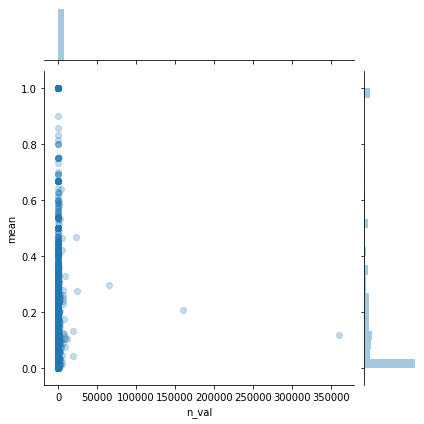

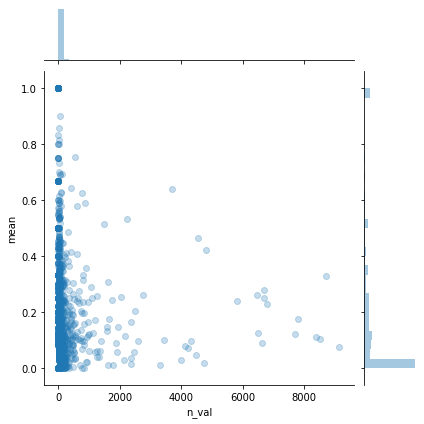

In [36]:
col = 'site_id'
a = pd.DataFrame([df.groupby(col).mean()['click'], df.groupby(col).count()['click']]).transpose()
a.columns = ['mean', 'n_val']
sns.jointplot(a['n_val'], a['mean'], alpha=0.25);
thres = 10000
sns.jointplot(a[a['n_val']<thres]['n_val'], a[a['n_val']<thres]['mean'], alpha=0.25);

<font color="red">**Question:**
    In the above commands, what does the alpha parameter stand for?
</font>

<font color="blue"> Alpha represent the opacity of the points. And we note that where opacity is higher, it is because points are overlapping. </font>

Several sites with a lot of occurrences in the dataset have a click frequency very different from the mean. It is relevant to keep the column 'site_id' at least for the modalities for which 'count' is very high.

<font color="red">**Question:**
    Do the same work on the 'device_id' column. What do you notice? What could be the isolated point?
</font>

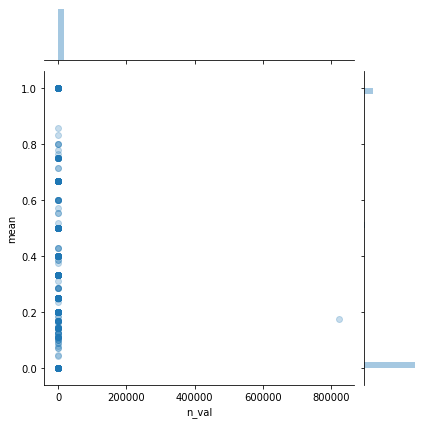

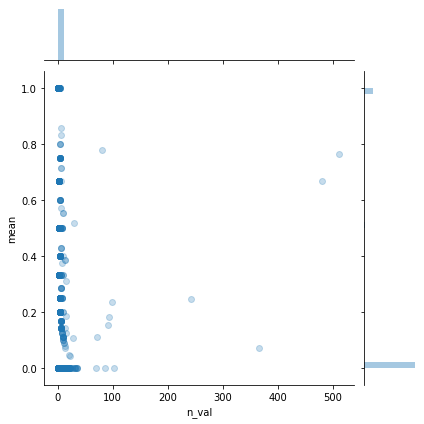

In [37]:
col = 'device_id' # Fill here
a = pd.DataFrame([df.groupby(col).mean()['click'], df.groupby(col).count()['click']]).transpose()
a.columns = ['mean', 'n_val']
sns.jointplot(a['n_val'], a['mean'], alpha=0.25);
thres = 10000
sns.jointplot(a[a['n_val']<thres]['n_val'], a[a['n_val']<thres]['mean'], alpha=0.25);

<font color="blue"> The unique spot values corresponds to people which devices block the users information so the website associate a standard ID to these users. That's why, the unique spot values have a big n_value. </font>

<font color="red">**Question**:   
    In the column df['device_id'], spot the value V corresponding to the largest number of 'count' (using '.value_counts' method). Create a new column df['user'] defined as follows:
</font>
$$
\text{user} = \left\{\begin{array}[h]{ll} \text{device_ip + device_model} & \text{if device_id = V}\\ \text{device_id} & \text{else.}\end{array}\right.
$$

In [38]:
V = df['device_id'].value_counts().idxmax() # Fill here
df['user'] = (df['device_ip'] + df['device_model']) * (df['device_id']==V) + df['device_id'] * (df['device_id']!=V)

<font color="red">**Question**:
    Drop the following columns: 'device_id', 'device_model' and 'device_ip'
</font>

In [39]:
df = df.drop(['device_id','device_model','device_ip'], axis=1)

<font color="red">**Question**:
    One could look at the similarity between 'site_id' and 'site_domain'. Merge those columns into a new 'site' column (using the '+' operator)  and delete the old 'site_id' and 'site_domain' columns.
</font>

In [40]:
df['site'] = df['site_id'] + df['site_domain']
df = df.drop(['site_id', 'site_domain'], axis=1)

<font color="red">**Question**:
    Once again, split the modified DataFrame 'df' into a train and a test set (with options: test_size=0.1 and random_state=100).
    <br>
    Warning: do not use 'id' as a feature.
</font>

In [41]:
X = df.drop(['id','click'], axis=1)
y = df['click']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=100)

In [42]:
Xtrain.shape

(900000, 20)

<font color="red">**Question**:
    Define a OneHotEncoder and then, 'fit_transform' the train set.
</font>

In [43]:
ohe = OneHotEncoder(handle_unknown='ignore')
Xtrain_oh = ohe.fit_transform(Xtrain) # Fill here

<font color="red">**Question**:
    Transform the test set. If an error occurs, analyze it and try to solve it by modifying the parameter "handle_unkown" of the OneHotEncoder. 
    <br>
    Explain your the problem you encouter and how you solved it. 
</font>

In [44]:
Xtest_oh = ohe.transform(Xtest) # Fill here

<font color="blue"> The test dataset has categorical features that don't appear in the train dataset, the parameter "handle_unknown='ignore'" permit to solve this problem by ignoring these features. </font>

<font color="red">**Question**:
    What is the new number of features?
</font>

In [45]:
Xtest_oh.shape[1]

713334

<font color="blue"> There are 713334 features. </font>

<font color="red">**Question**:
    How many modalities have been seen more than a 100 times?
</font>

In [46]:
# The following 'n_ones' vector below gives the number of '1' in each column/modality of the Xtrain_oh design matrix.
n_ones = np.array(Xtrain_oh.sum(axis=0))
np.sum(n_ones> 100) # Fill here using 'n_ones'

1971

<font color="blue"> There are only 1971 modalities which have been seen more than 100 times. </font>

The list 'cols_to_keep' below is used to store the indices of the modalities seen more than a 100 times. 

<font color="red">**Question**:
    How does the `enumerate` function work?
</font>

In [47]:
useful = np.array(n_ones>100)[0]
cols_to_keep = [i for i,b in enumerate(useful) if b]

<font color="blue"> The enumerate function associate the index of the columns which have been seen more than 100 times. </font>

<font color="red">**Question**:
    Using only our restriction on the 'cols_to_keep' columns, retrain a logistic regression model and compare its performance in terms of 'log_loss' and 'roc_auc_curve'.
</font>

In [48]:
lr = LogisticRegression(solver='liblinear')
lr.fit(Xtrain_oh[:,cols_to_keep], ytrain)
soft = lr.predict_proba(Xtest_oh[:,cols_to_keep])
log_loss(ytest, soft[:,1]), roc_auc_score(ytest, soft[:,1])

(0.40115580757357305, 0.7385966313684806)

# Gradient Boosting Decision Trees

<font color="red">**Question**:
    <br> - Import GradientBoostingClassifier from scikit learn. 
    <br> - Initialize it using 50 estimators and a learning rate of 0.8. Set 'verbose=True' to monitor the progress of the training step.
    <br> - Fit it on the same columns 'cols_to_keep' of Xtrain_oh than for the previous logistic regression.
    <br> - Evaluate its performance as in the previous step.
</font>

In [46]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=50, learning_rate=0.8, verbose=True) # Fill here

In [47]:
gb.fit(Xtrain_oh[:,cols_to_keep], ytrain)

      Iter       Train Loss   Remaining Time 
         1           0.8743            4.18m
         2           0.8646            4.05m
         3           0.8583            4.50m
         4           0.8535            4.27m
         5           0.8503            4.09m
         6           0.8464            3.95m
         7           0.8441            3.82m
         8           0.8418            3.68m
         9           0.8404            3.54m
        10           0.8383            3.42m
        20           0.8282            2.43m
        30           0.8234            1.59m
        40           0.8190           47.17s
        50           0.8163            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.8, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=True,
                           warm_start=False)

In [48]:
soft = gb.predict_proba(Xtest_oh[:,cols_to_keep])
log_loss(ytest, soft[:,1]), roc_auc_score(ytest, soft[:,1])

(0.4091871736006742, 0.7251893509766301)

<font color="red">**Question**:
    What does the 'gb.estimators_' output?
</font>

In [49]:
gb.estimators_

array([[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort='auto',
                      random_state=<mtrand.RandomState object at 0x000002960D231728>,
                      splitter='best')],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort='auto',
                      random_state=<mtrand.RandomState object at 0x000002960D231728>,
                      splitter='best')],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, max_f

<font color="blue"> It displays all trees estimators of the Gradient Boosting estimator. </font>

We now try to use the 'gb' classifier to generate features that will be relevant inputs for the logistic regression.

<font color="red">**Question**:
    With the 'gb.apply()' method, generate a transformation 'leafs_train' of the training set 'Xtrain_oh[:, cols_to_keep]' for which the n-th column corresponds to the number of the leaf returned by the estimator n.
</font>

In [50]:
# Test here the gb.apply method on Xtrain[:, cols_to_keep]
gb.apply(Xtrain_oh[:, cols_to_keep])

array([[[ 3.],
        [ 3.],
        [ 3.],
        ...,
        [ 3.],
        [ 3.],
        [ 3.]],

       [[ 3.],
        [ 3.],
        [ 3.],
        ...,
        [ 3.],
        [ 3.],
        [ 3.]],

       [[ 3.],
        [ 3.],
        [ 3.],
        ...,
        [ 3.],
        [ 3.],
        [ 3.]],

       ...,

       [[ 3.],
        [ 3.],
        [ 3.],
        ...,
        [ 3.],
        [ 3.],
        [ 3.]],

       [[ 3.],
        [ 3.],
        [ 3.],
        ...,
        [ 3.],
        [ 3.],
        [ 3.]],

       [[ 3.],
        [13.],
        [ 3.],
        ...,
        [ 3.],
        [ 3.],
        [ 3.]]])

After your applied gb.apply on Xtrain_oh[:, cols_to_keep], remember that we have only one class to predict (click = 0 or 1). So, do not forget to slice your output with [:, :, 0] in order to keep, firstly, all the samples, and secondly all your 50 estimators.

Hint: you can have a look at the dimensions of your output with .shape !

In [51]:
leafs_train = pd.DataFrame(gb.apply(Xtrain_oh[:, cols_to_keep])[:,:,0]) # Fill here
leafs_test = pd.DataFrame(gb.apply(Xtest_oh[:, cols_to_keep])[:,:,0])

<font color="red">**Question**:
    Encode these new features into dummies.
</font>

In [52]:
ohe = OneHotEncoder(handle_unknown='ignore') # Fill here an argument if needed
leafs_train_oh = ohe.fit_transform(leafs_train)
leafs_test_oh = ohe.transform(leafs_test)

<font color="red">**Question**:
    With the "hstack" function, create a new matrix of features by concatenating horizontally our new features "leafs_train_oh" and "leafs_test_oh", and previous features used for logistic regression (e.g. in "Xtrain_oh[:, cols_to_keep]").
</font>
<br><br>
**Remark**: we use "hstack" from scipy.sparse (and not from numpy) because the output of our OneHotEncoder is a sparse array. You can verify it with the command "type(Xtrain_oh)".

In [53]:
from scipy.sparse import csr_matrix, hstack

Xtrain_concat = hstack([ leafs_train_oh , Xtrain_oh[:,cols_to_keep] ]) # Fill here
Xtest_concat = hstack([ leafs_test_oh , Xtest_oh[:,cols_to_keep] ])

<font color="red">**Question**:
    Run a logistic regression on the new features and evaluate its performance as before. 
    <br>
    Warning: be patient, fitting should take about 5 minutes on Google Colab.
</font>

In [54]:
lr = LogisticRegression(solver='liblinear')
lr.fit(Xtrain_concat, ytrain)
soft = lr.predict_proba(Xtest_concat)
log_loss(ytest, soft[:,1]), roc_auc_score(ytest, soft[:,1])

(0.3999485273288263, 0.7417408521229629)

<font color="red">**Question**:
    <br> - Import XGBClassifier from xgboost package.
    <br> - Initialize it using the same number of estimators and learning rate as before. Set the 'n_jobs' to -1.
    <br> - Fit it on the same columns 'cols_to_keep' of Xtrain_oh than for the previous logistic regression.
    <br> - Evaluate its performance and compare it to the GradientBoosting classifier of scikit learn. How is the error? Does it take more time to run?
</font>

In [55]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=50 , learning_rate=0.8, n_jobs=-1)
%time xgb.fit(Xtrain_oh[:,cols_to_keep], ytrain)
soft = xgb.predict_proba(Xtest_oh[:,cols_to_keep])
log_loss(ytest, soft[:,1]), roc_auc_score(ytest, soft[:,1])

Wall time: 42.5 s


(0.40789666037925987, 0.7244454605414952)

<font color="blue"> The error is smaller than for the GradientBoosting classifier (+ new features and LogisticRegressions) and it is faster. </font>

<font color="red">**Question**:
    Increase the number of estimators and visualize the impact on performance. You might have to adapt the learning rate. On Google Colab, here are the approximate training times
    <br> - nb_estimators=256  and lr=0.8 ~  4 min
    <br> - nb_estimators=512  and lr=0.6 ~  8 min
    <br> - nb_estimators=1024 and lr=0.5 ~ 16 min
</font>

In [56]:
xgb = XGBClassifier( n_estimators=256 , learning_rate=0.8, n_jobs=-1)
%time xgb.fit(Xtrain_oh[:,cols_to_keep], ytrain)
soft = xgb.predict_proba(Xtest_oh[:,cols_to_keep])
print(log_loss(ytest, soft[:,1]), roc_auc_score(ytest, soft[:,1]))

xgb = XGBClassifier( n_estimators=512 , learning_rate=0.6, n_jobs=-1)
%time xgb.fit(Xtrain_oh[:,cols_to_keep], ytrain)
soft = xgb.predict_proba(Xtest_oh[:,cols_to_keep])
print(log_loss(ytest, soft[:,1]), roc_auc_score(ytest, soft[:,1]))

xgb = XGBClassifier( n_estimators=1024 , learning_rate=0.5, n_jobs=-1)
%time xgb.fit(Xtrain_oh[:,cols_to_keep], ytrain)
soft = xgb.predict_proba(Xtest_oh[:,cols_to_keep])
print(log_loss(ytest, soft[:,1]), roc_auc_score(ytest, soft[:,1]))

Wall time: 2min 27s
0.4005939307126671 0.7398873318043857
Wall time: 5min 22s
0.3989405887436692 0.7430728546666654
Wall time: 9min 4s
0.39833280929639514 0.7443511768722024


# Features hashing and random forest

We restart with raw features before dummy encoding: Xtrain, Xtest.

<font color="red">**Question**:
    Display again the number of modalities per feature in Xtrain. Use '.nunique()'
</font>

In [57]:
Xtrain.nunique()# Fill here

hour                    24
C1                       7
banner_pos               7
site_category           22
app_id                3054
app_domain             196
app_category            26
device_type              5
device_conn_type         4
C14                   2225
C15                      8
C16                      9
C17                    420
C18                      4
C19                     66
C20                    163
C21                     60
weekday                  7
user                701585
site                  5442
dtype: int64

We want to define a transformation which regroups the least frequent modalities into a label 'isRare'. In order to do so, we decide to define our own Transformer.

<font color="red">**Question**:
    Understand the different steps of 'fit' and 'transform'.
</font>

In [80]:
from sklearn.base import BaseEstimator, TransformerMixin

class MergeRareTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, col_names, threshold):
        self.col_names = col_names
        self.threshold = threshold

    def fit(self, X, y=None):

        X = pd.DataFrame(X)
        counts_dict_list = []
        ################## READ THIS #########################
        for i in range(len(self.col_names)):
            
            serie = X[self.col_names[i]].value_counts()  # Série des counts de chaque modalité
            rare_indexes = serie[serie<self.threshold[i]].index  # A quoi correspondent ces indices ? les indices des observations rares
            frequent_indexes = serie[serie>=self.threshold[i]].index  # A quoi correspondent ces indices ? les indices des observations fréquentes
            dico = {x:'isRare' for x in rare_indexes}
            dico.update({x: str(x) for x in frequent_indexes})
            counts_dict_list.append(dico)   # Quel est le dictionnaire obtenu ? les observations rares ont un label isRare, les autres ont leur label original
            
        ######################################################
            
        self.counts_dict_list_ = counts_dict_list
        return self

    def transform(self, X):

        Xt = pd.DataFrame()
        ################## READ THIS #########################
        for col, count_dict in zip(self.col_names, self.counts_dict_list_):
            Xt[col] = X[col].apply(lambda x:count_dict[x] if x in count_dict else 'isRare')
            # A quoi sert le "else 'isRare'" dans la transformation de la colonne ?
        ######################################################

        return Xt


<font color="red">**Question:**
    <br> - Fit and transform the training set. To do so, merge all modalities occuring at least 20 times in each column.
    <br> - Transform the test set.
</font>

In [81]:
mg = MergeRareTransformer(col_names=Xtrain.columns, threshold=[20]*len(Xtrain.columns))
Xtrain_mg = mg.fit_transform(Xtrain) # Fill here with fit_transform
Xtest_mg  = mg.transform(Xtest)

<font color="red">**Question:**
   How many elements of the column Xtrain_mg['app_domain'] are now labeled as 'rare'? Use the '.value_counts()' method.
</font>

In [60]:
Xtrain_mg['app_domain'].value_counts() # Fill here

7801e8d9    606390
2347f47a    116467
ae637522     41928
5c5a694b     25289
82e27996     16869
d9b5648e     15709
0e8616ad     14784
b9528b13     14284
b8d325c3     11953
aefc06bd      6644
df32afa9      6412
33da2e74      5911
6f7ca2ba      4990
5b9c592b      2448
885c7f3f      1468
5c620f04      1419
45a51db4      1219
b5f3b24a      1093
813f3323       544
0654b444       514
isRare         513
ad63ec9b       388
c6824def       306
15ec7f39       275
a8b0bf20       266
99b4c806       219
828da833       185
448ca2e3       167
f2f777fb       157
43cf4f06       149
47464e95        99
d6feb1a4        95
2b627705        89
1ea19ec4        72
db829551        69
6a0a3a9d        59
18eb4e75        56
0d79ee56        53
9ec164d3        51
e5d5313f        46
b12ff13e        42
27ee373d        36
b408d42a        30
5ac0b939        28
bb6bcbae        27
1ed56ded        27
3feeed1e        26
63f57be0        25
15c23f8e        25
7eec2ab0        24
7a9371fa        21
afdf1f54        20
dcdba109    

<font color="blue"> There are 513 elements labeled as 'isRare'. </font>

<font color="red">**Question:**
   In the new train set, display the number of modalities for each feature.
</font>

In [61]:
Xtrain_mg.nunique()# Fill here

hour                  24
C1                     7
banner_pos             7
site_category         18
app_id               613
app_domain            53
app_category          19
device_type            5
device_conn_type       4
C14                 1339
C15                    8
C16                    9
C17                  381
C18                    4
C19                   63
C20                  148
C21                   60
weekday                7
user                 901
site                 889
dtype: int64

Modalities are arbitrary object, such as '234', 'isRare', etc. We will now transform them into integers with the hashing trick.

<font color="red">**Question:**
   To better understand how the 'hash' function is working, apply it to a string of your choice.
</font>

In [54]:
import hashlib
hash('Python')

-6990983340402408668

<font color="red">**Question:**
   Create two new datasets 'Xtrain_ha' and 'Xtest_ha' containing the output of the hashing process. Use the '.apply' method to transform iteratively the columns by mapping to each value its remainder in the euclidean division of the hash by 1000000. 
   Example:
</font>
</font>
<p>
<center>
2060777048690<font color="red">918393</font>  -->  918393
</center>
Remark: do not forget that the function 'hash' has to take a string as input.

In [63]:
Xtrain_ha = pd.DataFrame()
Xtest_ha  = pd.DataFrame()
for col in Xtrain_mg.columns:
    Xtrain_ha[col] = Xtrain_mg[col].apply(lambda x : hash(str(x)) % 1000000) # Fill here defining a lambda function
    Xtest_ha[col]  = Xtest_mg[col].apply(lambda x : hash(str(x)) % 1000000)

<font color="red">**Question:**
   Visualize the content of the DataFrames you have obtained.
</font>

In [64]:
Xtrain_ha.head()

,hour,C1,banner_pos,site_category,app_id,app_domain,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday,user,site
92438,495490,886536,425377,296665,659262,724821,703468,55443,153260,695606,480142,433485,381219,422796,361883,898198,531487,422796,530172,54646
60898,991348,905481,422796,296665,768851,483115,473321,425377,380713,695606,480142,433485,381219,422796,361883,898198,531487,425377,530172,54646
556199,55443,905481,422796,682631,355081,724821,307517,425377,380713,566593,480142,433485,306476,422796,783471,898198,212749,422796,530172,478932
193129,996369,905481,425377,682631,355081,724821,307517,425377,422796,112886,480142,433485,432915,422796,684406,640640,168806,425377,530172,314831
231985,764835,905481,422796,494541,355081,724821,307517,425377,422796,162812,480142,433485,381219,422796,361883,871298,531487,727383,530172,679108


<font color="red">**Question:**
    <br> - Train a RandomForestClassifier on Xtrain_ha and evaluate its performance on Xtest_ha. Chose 256 estimators, min_samples_leaf=20 and verbose=1 in order to monitor the fitting step. (If you have enough time, try later with 1024 estimators and min_samples_leaf=20).
    <br> - How do you fix 'n_jobs'? 
</font>

In [65]:
from sklearn.ensemble import RandomForestClassifier # Fill here
rf = RandomForestClassifier(n_estimators=256,min_samples_leaf=20,verbose=1,n_jobs=-1)
rf.fit(Xtrain_ha, ytrain )

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:  5.6min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=256,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

In [66]:
soft = rf.predict_proba(Xtest_ha)
log_loss(ytest, soft[:,1]), roc_auc_score(ytest, soft[:,1])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 256 out of 256 | elapsed:    3.0s finished


(0.401108210463943, 0.740587901090798)

<font color="red">**Question:**
   Compare with xgboost performance on the same hashed dataset, with n_estimators=256, n_jobs=-1, learning_rate=1.0. (If you have enough time try n_estimators=1024, n_jobs=-1, learning_rate=0.5, it will perform better than a Random Forest of 1024 trees).
</font>

In [67]:
xgb = XGBClassifier(n_estimators=256, learning_rate=1, n_jobs=-1)
%time xgb.fit(Xtrain_ha, ytrain)
soft = xgb.predict_proba(Xtest_ha)
log_loss(ytest, soft[:,1]), roc_auc_score(ytest, soft[:,1])

Wall time: 2min 44s
nan 0.7360900501720615


C:\Users\julien.LAPTOP-V4T667QN\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Users\julien.LAPTOP-V4T667QN\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


<font color="red">**Question:**
    Plot the ROC and the lift curves for the obtained classifier (xgboost on hashed data). What is the lift of the first fifth of the population identified by the test?
</font>

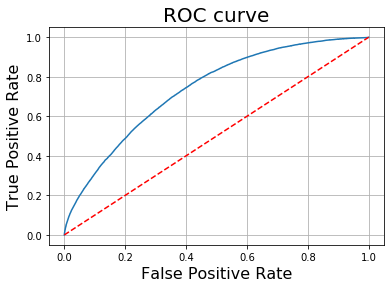

In [68]:
false_pos_rate, true_pos_rate, _ = roc_curve(ytest, soft[:,1])
plt.plot(false_pos_rate, true_pos_rate)

plt.grid()
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=20)
plt.show()

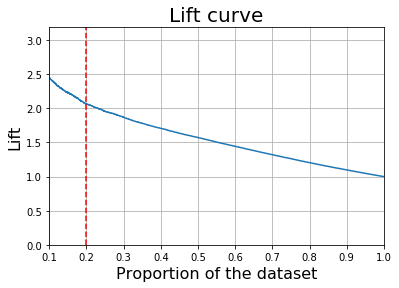

In [69]:
plotlift(ytest, soft[:,1] )
# The following line just plots a vertical line for you to answer the second part of the question
plt.axvline(x= 0.2 , linestyle='--', color='r') # Fill here
plt.text
plt.xlabel('Proportion of the dataset', fontsize=16)
plt.ylabel('Lift', fontsize=16)
plt.title('Lift curve', fontsize=20)
plt.show()

<font color="blue"> The lift for the 1st fifth of the population is around 2.1. </font>

Hashing produces columns of integers arbitrarily ordered. One can wonder if adding more columns hashed in a different fashion would lead to better performance. 

<font color="red">**Question:**
    Add hashed columns by recursively hashing the previous ones: complete the following code. 
</font>

In [70]:
Xtrain_haha = pd.DataFrame(Xtrain_ha).copy()
Xtest_haha  = pd.DataFrame(Xtest_ha).copy()

n_hash = 3
cols   = Xtrain_ha.columns
for l in range(n_hash):
    for col in cols:
        Xtrain_haha[col + '-hash'] = Xtrain_haha[col].apply(lambda x : hash(str(x)) % 1000000)
        Xtest_haha[col + '-hash']  = Xtest_haha[col].apply(lambda x : hash(str(x)) % 1000000)
    cols = [col + '-hash' for col in cols]

<font color="red">**Question:**
    Evaluate the performance of a random forest and/or an xgboost clasifier (chose 256 estimators first and learning rate of 1.0 for xgboost) on these enlarged dataset. Is the performance better than when hasing features once?
</font>

In [71]:
rf = RandomForestClassifier(n_estimators=256,min_samples_leaf=20,verbose=1,n_jobs=-1)
rf.fit(Xtrain_haha, ytrain)
soft = rf.predict_proba(Xtest_haha)
log_loss(ytest, soft[:,1]), roc_auc_score(ytest, soft[:,1])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:  9.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 256 out of 256 | elapsed:    4.1s finished


(0.3987364115507108, 0.7446770007531023)

In [72]:
xgb = XGBClassifier(n_estimators=256, learning_rate=1, n_jobs=-1)
%time xgb.fit(Xtrain_haha, ytrain)
soft = xgb.predict_proba(Xtest_haha)
print(log_loss(ytest, soft[:,1]), roc_auc_score(ytest, soft[:,1]))

Wall time: 7min 47s
0.40049972233188286 0.74150736517038


<font color="blue"> It seems that for RandomForest log_loss is a bit smaller and roc_auc_score quasi-equivalent . And for XGBoost no significative changes appear . </font>

Good job! :-) 

<font color="red">**Bonus Question:**
    If you have enough time (about 2 hours ...), try to fit both random forest and xgboost models with 1024 estimators (and a learning rate of 0.5 for xgboost) on these enlarged datasets.
    <br> - Which one performs better?
    <br> - Can you see the improvement due to the addition of more hashed features?
</font>

In [73]:
# Fill here

# Field-aware Factorization Machines
<br>
<font color="red">
Display the names of the columns of the matrix Xtrain_ha
</font>

In [74]:
Xtrain_ha.columns

Index(['hour', 'C1', 'banner_pos', 'site_category', 'app_id', 'app_domain',
       'app_category', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C20', 'C21', 'weekday', 'user', 'site'],
      dtype='object')

<font color="red">
Create a list of lists of the columns. The n-th sub-list is composed of the names of the columns of the n-th field.</font>

In [93]:
fields = []
fields.append( ['hour','weekday'] )
fields.append( ['app_id','app_domain','app_category'] )
fields.append( ['device_type', 'device_conn_type'] )
fields.append( ['site_category', 'site'] )
fields.append( ['C1','C14','C15','C16','C17','C18','C19','C20','C21'] )
fields.append( ['banner_pos'] )
fields.append( ['user'] )

<font color="red">
With the enumerate function, let generate a dictionary which associates each column name with its field.


In [94]:
dicFields = {name_col: i for i,f in enumerate(fields) for name_col in f}
dicFields

{'hour': 0,
 'weekday': 0,
 'app_id': 1,
 'app_domain': 1,
 'app_category': 1,
 'device_type': 2,
 'device_conn_type': 2,
 'site_category': 3,
 'site': 3,
 'C1': 4,
 'C14': 4,
 'C15': 4,
 'C16': 4,
 'C17': 4,
 'C18': 4,
 'C19': 4,
 'C20': 4,
 'C21': 4,
 'banner_pos': 5,
 'user': 6}

We need to make sure that two different columns have different modalities. For this, we add in front of each modality a characteristic string of the column.

<font color="red">Perform this transformation with the apply method</font>


In [77]:
Xtrain_ffm = pd.DataFrame()
Xtest_ffm  = pd.DataFrame()
for col in Xtrain_ha.columns:
    Xtrain_ffm[col] = Xtrain_ha[col].apply( lambda x : str(col) + '_' + str(x)) #int(str(hash(str(col)) % 1000000) + str(x)))
    Xtest_ffm[col]  = Xtest_ha[col].apply( lambda x : str(col) + '_' + str(x))
Xtrain_ffm.head()

,hour,C1,banner_pos,site_category,app_id,app_domain,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday,user,site
92438,hour_495490,C1_886536,banner_pos_425377,site_category_296665,app_id_659262,app_domain_724821,app_category_703468,device_type_55443,device_conn_type_153260,C14_695606,C15_480142,C16_433485,C17_381219,C18_422796,C19_361883,C20_898198,C21_531487,weekday_422796,user_530172,site_54646
60898,hour_991348,C1_905481,banner_pos_422796,site_category_296665,app_id_768851,app_domain_483115,app_category_473321,device_type_425377,device_conn_type_380713,C14_695606,C15_480142,C16_433485,C17_381219,C18_422796,C19_361883,C20_898198,C21_531487,weekday_425377,user_530172,site_54646
556199,hour_55443,C1_905481,banner_pos_422796,site_category_682631,app_id_355081,app_domain_724821,app_category_307517,device_type_425377,device_conn_type_380713,C14_566593,C15_480142,C16_433485,C17_306476,C18_422796,C19_783471,C20_898198,C21_212749,weekday_422796,user_530172,site_478932
193129,hour_996369,C1_905481,banner_pos_425377,site_category_682631,app_id_355081,app_domain_724821,app_category_307517,device_type_425377,device_conn_type_422796,C14_112886,C15_480142,C16_433485,C17_432915,C18_422796,C19_684406,C20_640640,C21_168806,weekday_425377,user_530172,site_314831
231985,hour_764835,C1_905481,banner_pos_422796,site_category_494541,app_id_355081,app_domain_724821,app_category_307517,device_type_425377,device_conn_type_422796,C14_162812,C15_480142,C16_433485,C17_381219,C18_422796,C19_361883,C20_871298,C21_531487,weekday_727383,user_530172,site_679108


With np.unique, we create the list of all the modalities appearing in all the columns.

In [78]:
allvals = []
allcols_ffm = [col for f in fields for col in f]  # Toutes les colonnes appartenant à l'un des champ
for col in allcols_ffm:
    allvals.append(np.unique(Xtrain_ffm[col]))
allvals = [val for sublist in allvals for val in sublist]

<font color="red">
Using enumerate method, create a dictionary that at each value associates its rank in the allvals list.</font>

In [79]:
dicFeat = {val:i for i,val in enumerate(allvals) }
dicFeat

{'hour_151332': 0,
 'hour_153260': 1,
 'hour_283377': 2,
 'hour_289785': 3,
 'hour_292274': 4,
 'hour_380713': 5,
 'hour_387270': 6,
 'hour_392013': 7,
 'hour_422796': 8,
 'hour_423691': 9,
 'hour_425308': 10,
 'hour_425377': 11,
 'hour_495490': 12,
 'hour_55443': 13,
 'hour_727383': 14,
 'hour_764835': 15,
 'hour_771754': 16,
 'hour_80302': 17,
 'hour_8276': 18,
 'hour_940972': 19,
 'hour_987446': 20,
 'hour_991348': 21,
 'hour_994737': 22,
 'hour_996369': 23,
 'weekday_153260': 24,
 'weekday_380713': 25,
 'weekday_422796': 26,
 'weekday_423691': 27,
 'weekday_425377': 28,
 'weekday_55443': 29,
 'weekday_727383': 30,
 'app_id_102710': 31,
 'app_id_104415': 32,
 'app_id_105413': 33,
 'app_id_106939': 34,
 'app_id_107647': 35,
 'app_id_108404': 36,
 'app_id_108553': 37,
 'app_id_109600': 38,
 'app_id_110990': 39,
 'app_id_113711': 40,
 'app_id_115174': 41,
 'app_id_122499': 42,
 'app_id_122599': 43,
 'app_id_123388': 44,
 'app_id_123966': 45,
 'app_id_124312': 46,
 'app_id_12639': 47,
 

We build dataframe from dicFeat as follows:
in each "col" column, the value "x" is replaced by the string "f: v: 1", where f is the field associated with the column and v is the index of the modality x.
<font color="red">
Study the following code</font>

In [80]:
for col in allcols_ffm:
    f = dicFields[col]
    Xtrain_ffm[col] = Xtrain_ffm[col].apply(lambda x:"{}:{}:1".format(f,dicFeat[x]) if x in dicFeat else "")
    Xtest_ffm[col]  = Xtest_ffm[col].apply(lambda x:"{}:{}:1".format(f,dicFeat[x]) if x in dicFeat else "")
Xtrain_ffm.head()

,hour,C1,banner_pos,site_category,app_id,app_domain,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday,user,site
92438,0:12:1,4:1636:1,5:3655:1,3:727:1,1:414:1,1:679:1,1:710:1,2:720:1,2:721:1,4:2558:1,4:2980:1,4:2987:1,4:3110:1,4:3377:1,4:3397:1,4:3574:1,4:3625:1,0:26:1,6:4074:1,3:1170:1
60898,0:21:1,4:1637:1,5:3652:1,3:727:1,1:487:1,1:666:1,1:706:1,2:718:1,2:722:1,4:2558:1,4:2980:1,4:2987:1,4:3110:1,4:3377:1,4:3397:1,4:3574:1,4:3625:1,0:28:1,6:4074:1,3:1170:1
556199,0:13:1,4:1637:1,5:3652:1,3:738:1,1:212:1,1:679:1,1:701:1,2:718:1,2:722:1,4:2351:1,4:2980:1,4:2987:1,4:3081:1,4:3377:1,4:3430:1,4:3574:1,4:3597:1,0:26:1,6:4074:1,3:1116:1
193129,0:23:1,4:1637:1,5:3655:1,3:738:1,1:212:1,1:679:1,1:701:1,2:718:1,2:723:1,4:1653:1,4:2980:1,4:2987:1,4:3128:1,4:3377:1,4:3422:1,4:3536:1,4:3594:1,0:28:1,6:4074:1,3:953:1
231985,0:15:1,4:1637:1,5:3652:1,3:732:1,1:212:1,1:679:1,1:701:1,2:718:1,2:723:1,4:1732:1,4:2980:1,4:2987:1,4:3110:1,4:3377:1,4:3397:1,4:3571:1,4:3625:1,0:30:1,6:4074:1,3:1305:1


<font color="red">For the two resulting dataframes, concatenate on the left the corresponding ytrain (or ytest) click column</font>

In [81]:
yXtrain_ffm = pd.concat( (ytrain.apply(str), Xtrain_ffm) , axis=1)
yXtest_ffm  = pd.concat( (ytest.apply(str), Xtest_ffm) , axis=1)
yXtrain_ffm.head()

,click,hour,C1,banner_pos,site_category,app_id,app_domain,app_category,device_type,device_conn_type,...,C15,C16,C17,C18,C19,C20,C21,weekday,user,site
92438,1,0:12:1,4:1636:1,5:3655:1,3:727:1,1:414:1,1:679:1,1:710:1,2:720:1,2:721:1,...,4:2980:1,4:2987:1,4:3110:1,4:3377:1,4:3397:1,4:3574:1,4:3625:1,0:26:1,6:4074:1,3:1170:1
60898,0,0:21:1,4:1637:1,5:3652:1,3:727:1,1:487:1,1:666:1,1:706:1,2:718:1,2:722:1,...,4:2980:1,4:2987:1,4:3110:1,4:3377:1,4:3397:1,4:3574:1,4:3625:1,0:28:1,6:4074:1,3:1170:1
556199,0,0:13:1,4:1637:1,5:3652:1,3:738:1,1:212:1,1:679:1,1:701:1,2:718:1,2:722:1,...,4:2980:1,4:2987:1,4:3081:1,4:3377:1,4:3430:1,4:3574:1,4:3597:1,0:26:1,6:4074:1,3:1116:1
193129,0,0:23:1,4:1637:1,5:3655:1,3:738:1,1:212:1,1:679:1,1:701:1,2:718:1,2:723:1,...,4:2980:1,4:2987:1,4:3128:1,4:3377:1,4:3422:1,4:3536:1,4:3594:1,0:28:1,6:4074:1,3:953:1
231985,0,0:15:1,4:1637:1,5:3652:1,3:732:1,1:212:1,1:679:1,1:701:1,2:718:1,2:723:1,...,4:2980:1,4:2987:1,4:3110:1,4:3377:1,4:3397:1,4:3571:1,4:3625:1,0:30:1,6:4074:1,3:1305:1


<font color="red">What does the following cell produce?</font>

In [111]:
train_w = yXtrain_ffm.apply(lambda row:' '.join(row.values),axis=1).values
test_w  = yXtest_ffm.apply(lambda row:' '.join(row.values),axis=1).values

<font color="blue"> It merges columns, we have now an array of 900000 long strings. </font>

<font color="red">Write the above dataframe in a text file</font>

In [112]:
thefile = open('data_tp/train.txt','w')
for item in train_w:
    thefile.write("%s\n" % item)
thefile.close()

# Faire de même pour le test set
thefile = open('data_tp/test.txt','w')
for item in test_w:
    thefile.write("%s\n" % item)
thefile.close()

To learn the FFM model, we use the LibFFM library https://www.csie.ntu.edu.tw/~cjlin/libffm/
In the notebooks / directory there are two executables: ffm-train and ffm-predict.
In jupyter notebook, the exclamation point! allows to launch a bash command.
The use is as follows:

-   `ffm-train'

    usage: ffm-train [options] training_set_file [model_file]

    options:  
    -l <lambda>: set regularization parameter (default 0.00002)  
    -k <factor>: set number of latent factors (default 4)  
    -t <iteration>: set number of iterations (default 15)  
    -r <eta>: set learning rate (default 0.2)  
    -s <nr_threads>: set number of threads (default 1)  
    -p <path>: set path to the validation set  
    --quiet: quiet model (no output)  
    --no-norm: disable instance-wise normalization  
    --auto-stop: stop at the iteration that achieves the best validation loss (must be used with -p)  
<br>
<font color="red">Learn the model. We can :
- use an regularizer of 0.00001
- use a learning rate of 0.05
- use of the order of 15 latent factors
- carry out the order of 30 iterations
- with the -p option, change the test file to validation parameters
- activate the --autostop mode
</font> 

In [113]:
!"libffm\windows\ffm-train" -l 0.00001 -r 0.05 -k 15 -t 30 --auto-stop -p "data_tp\test.txt" "data_tp\train.txt" "data_tp\model.txt"

First check if the text file has already been converted to binary format (0.5 seconds)
Binary file found. Skip converting text to binary
First check if the text file has already been converted to binary format (0.1 seconds)
Binary file found. Skip converting text to binary
iter   tr_logloss   va_logloss      tr_time
   1      0.41045      0.40370          5.5
   2      0.40276      0.40095         10.9
   3      0.40066      0.39930         17.0
   4      0.39946      0.39836         22.4
   5      0.39858      0.39797         27.8
   6      0.39791      0.39757         33.2
   7      0.39733      0.39745         38.5
   8      0.39685      0.39697         43.8
   9      0.39641      0.39679         49.5
  10      0.39599      0.39671         55.5
  11      0.39563      0.39654         60.9
  12      0.39531      0.39634         66.2
  13      0.39499      0.39634         71.7
  14      0.39468      0.39624         77.0
  15      0.39437      0.39603         82.3
  16      0.39410     

The use of ffm-predict is: ffm-predict filename-test file-name-model file-in-which-write-the-prediction 
<font color="red">Perform the prediction</font>

In [114]:
!"libffm\windows\ffm-predict" "data_tp\test.txt" "data_tp\model.txt" "data_tp\predict.txt"

logloss = 0.39603


In [120]:
y_predict = pd.read_csv('data_tp\predict.txt', header=None).values
y_predict

array([[0.323998 ],
       [0.44048  ],
       [0.0826991],
       ...,
       [0.230468 ],
       [0.198159 ],
       [0.0916288]])

<font color="red">Compute the log_loss and area under the roc curve (ROC AUC).</font>

In [121]:
log_loss(ytest, y_predict), roc_auc_score(ytest, y_predict)

(0.39602615449727846, 0.7496328876534711)

# Blending

<font color="red">
Split Xtrain in two: Xtrain_meth and Xtrain_blend.</font>

In [76]:
Xtrain_meth, Xtrain_blend, ytrain_meth, ytrain_blend = train_test_split(Xtrain, ytrain, test_size=0.2)

<font color="red">
Train a logistic regression on XTrain_meth. Then compute its score on Xtrain_blend and save the score in a vector.</font>

In [122]:
# PRE-PROCESSING
Xtrain_meth_oh  = ohe.fit_transform(Xtrain_meth)
Xtrain_blend_oh = ohe.transform(Xtrain_blend)
Xtest_blend_oh  = ohe.transform(Xtest)
n_ones = np.array(Xtrain_meth_oh.sum(axis=0))
useful = np.array(n_ones>100)[0]
cols_to_keep = [i for i,b in enumerate(useful) if b]

# FIT MODEL
lr = LogisticRegression(solver='liblinear')
lr.fit(Xtrain_meth_oh[:,cols_to_keep], ytrain_meth)
score_lr_train = lr.predict_proba(Xtrain_blend_oh[:,cols_to_keep])[:,1]
score_lr_test  = lr.predict_proba(Xtest_blend_oh[:,cols_to_keep])[:,1]

log_loss(ytrain_blend, score_lr_train), roc_auc_score(ytrain_blend, score_lr_train)

(0.40457823103564394, 0.7326136811731869)

<font color="red">
Do the same thing with XGBoost (save the score).</font>

In [123]:
# PRE-PROCESSING
Xtrain_meth_mg  = mg.fit_transform(Xtrain_meth) # Fill here with fit_transform
Xtrain_blend_mg = mg.transform(Xtrain_blend)
Xtest_blend_mg  = mg.transform(Xtest)
Xtrain_meth_ha  = pd.DataFrame()
Xtrain_blend_ha = pd.DataFrame()
Xtest_blend_ha  = pd.DataFrame()
for col in Xtrain_meth_mg.columns:
    Xtrain_meth_ha[col]  = Xtrain_meth_mg[col].apply(lambda x : hash(str(x)) % 1000000) # Fill here defining a lambda function
    Xtrain_blend_ha[col] = Xtrain_blend_mg[col].apply(lambda x : hash(str(x)) % 1000000)
    Xtest_blend_ha[col]  = Xtest_blend_mg[col].apply(lambda x : hash(str(x)) % 1000000)

# FIT MODEL
xgb = XGBClassifier(n_estimators=50, learning_rate=1, n_jobs=-1)
xgb.fit(Xtrain_meth_ha, ytrain_meth)
score_xgb_train = xgb.predict_proba(Xtrain_blend_ha)[:,1]
score_xgb_test  = xgb.predict_proba(Xtest_blend_ha)[:,1]

log_loss(ytrain_blend, score_xgb_train), roc_auc_score(ytrain_blend, score_xgb_train)

(0.41133290553098395, 0.7183222111342767)

<font color="red">
Do the same with a RandomForest (save the score).</font>

In [124]:
rf = RandomForestClassifier(n_estimators=256,min_samples_leaf=20,verbose=1,n_jobs=-1)
rf.fit(Xtrain_meth_ha, ytrain_meth)
score_rf_train = rf.predict_proba(Xtrain_blend_ha)[:,1]
score_rf_test = rf.predict_proba(Xtest_blend_ha)[:,1]

log_loss(ytrain_blend, score_rf_train), roc_auc_score(ytrain_blend, score_rf_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 256 out of 256 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 256 out of 256 | elapsed:    2.9s finished


(0.4044858178121832, 0.7344406839463467)

<font color="red">
Now with an extraTrees.</font>

In [125]:
from sklearn.ensemble import ExtraTreesClassifier
tr = ExtraTreesClassifier(n_estimators=100,min_samples_leaf=20)
tr.fit(Xtrain_meth_ha, ytrain_meth)
score_tr_train = tr.predict_proba(Xtrain_blend_ha)[:,1]
score_tr_test  = tr.predict_proba(Xtest_blend_ha)[:,1]

log_loss(ytrain_blend, score_tr_train), roc_auc_score(ytrain_blend, score_tr_train)

(0.40913314926636934, 0.7257579833860874)

<font color="red">
And again with FFM.</font>

In [126]:
# PRE-PROCESSING
Xtrain_meth_ffm  = pd.DataFrame()
Xtrain_blend_ffm = pd.DataFrame()
Xtest_blend_ffm  = pd.DataFrame()
for col in Xtrain_meth_ha.columns:
    Xtrain_meth_ffm[col]  = Xtrain_meth_ha[col].apply( lambda x : str(col) + '_' + str(x))
    Xtrain_blend_ffm[col] = Xtrain_blend_ha[col].apply( lambda x : str(col) + '_' + str(x))
    Xtest_blend_ffm[col]  = Xtest_blend_ha[col].apply( lambda x : str(col) + '_' + str(x))
allvals = []
allcols_ffm = [col for f in fields for col in f]  # Toutes les colonnes appartenant à l'un des champ
for col in allcols_ffm:
    allvals.append(np.unique(Xtrain_meth_ffm[col]))
allvals = [val for sublist in allvals for val in sublist]
dicFeat = {val:i for i,val in enumerate(allvals) }
for col in allcols_ffm:
    f = dicFields[col]
    Xtrain_meth_ffm[col]  = Xtrain_meth_ffm[col].apply(lambda x:"{}:{}:1".format(f,dicFeat[x]) if x in dicFeat else "")
    Xtrain_blend_ffm[col] = Xtrain_blend_ffm[col].apply(lambda x:"{}:{}:1".format(f,dicFeat[x]) if x in dicFeat else "")
    Xtest_blend_ffm[col]  = Xtest_blend_ffm[col].apply(lambda x:"{}:{}:1".format(f,dicFeat[x]) if x in dicFeat else "")

yXtrain_ffm  = pd.concat( (ytrain_meth.apply(str), Xtrain_meth_ffm) , axis=1)
yXtest_ffm   = pd.concat( (ytrain_blend.apply(str), Xtrain_blend_ffm) , axis=1)
yXtest_ffm_2 = pd.concat( (ytest.apply(str), Xtest_blend_ffm) , axis=1)     

train_blend  = yXtrain_ffm.apply(lambda row:' '.join(row.values),axis=1).values
test_blend   = yXtest_ffm.apply(lambda row:' '.join(row.values),axis=1).values 
test_blend_2 = yXtest_ffm_2.apply(lambda row:' '.join(row.values),axis=1).values       

thefile = open('data_tp/train_blend.txt','w')
for item in train_blend:
    thefile.write("%s\n" % item)
thefile.close()
thefile = open('data_tp/test_blend.txt','w')
for item in test_blend:
    thefile.write("%s\n" % item)
thefile.close()
thefile = open('data_tp/test_blend_2.txt','w')
for item in test_blend_2:
    thefile.write("%s\n" % item)
thefile.close()
# FIT MODEL
!"libffm\windows\ffm-train" -l 0.00001 -r 0.05 -k 15 -t 30 --auto-stop -p "data_tp\test_blend.txt" "data_tp\train_blend.txt" "data_tp\model_blend.txt"
!"libffm\windows\ffm-predict" "data_tp\test_blend.txt" "data_tp\model_blend.txt" "data_tp\predict_blend.txt"
!"libffm\windows\ffm-predict" "data_tp\test_blend_2.txt" "data_tp\model_blend.txt" "data_tp\predict_test.txt"
score_ffm_train = pd.read_csv('data_tp\predict_blend.txt', header=None).values.ravel()
score_ffm_test = pd.read_csv('data_tp\predict_test.txt', header=None).values.ravel()

log_loss(ytrain_blend, score_ffm_train), roc_auc_score(ytrain_blend, score_ffm_train)

First check if the text file has already been converted to binary format (0.6 seconds)
Binary file found. Skip converting text to binary
First check if the text file has already been converted to binary format (0.1 seconds)
Binary file found. Skip converting text to binary
iter   tr_logloss   va_logloss      tr_time
   1      0.41137      0.40672          5.7
   2      0.40321      0.40376         11.3
   3      0.40104      0.40265         16.7
   4      0.39973      0.40237         22.4
   5      0.39877      0.40138         27.8
   6      0.39807      0.40099         33.3
   7      0.39745      0.40071         38.6
   8      0.39694      0.40083
Auto-stop. Use model at 7th iteration.
logloss = 0.40071
logloss = 0.39799


(0.40071432615382624, 0.7417454789623831)

<font color="red">
Concatenate all scores on Xtrain_blend to form a Zblend design matrix.</font>

In [127]:
Zblend_train = np.concatenate((score_lr_train.reshape(-1,1), score_xgb_train.reshape(-1,1), score_rf_train.reshape(-1,1), score_tr_train.reshape(-1,1), score_ffm_train.reshape(-1,1)),axis=1)
Zblend_test  = np.concatenate((score_lr_test.reshape(-1,1), score_xgb_test.reshape(-1,1), score_rf_test.reshape(-1,1), score_tr_test.reshape(-1,1), score_ffm_test.reshape(-1,1)),axis=1)

<font color="red">
Train a logistic regression on (Zblend,ytrain_blend).</font>

In [128]:
# FIT MODEL
lr = LogisticRegression(solver='liblinear')
lr.fit(Zblend_train,ytrain_blend)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

<font color="red">
Evaluate the performance of this model on the test dataset.</font>

In [129]:
score_blend = lr.predict_proba(Zblend_test)[:,1]
log_loss(ytest, score_blend), roc_auc_score(ytest, score_blend)

(0.4026378743227604, 0.7474785596474428)

<font color="blue"> This blending doesn't seem to improve the classification. </font>